In [1]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from functools import reduce
from datetime import datetime
from termcolor import colored
from pickle import dump

from sklearn.preprocessing import Binarizer, OneHotEncoder, PowerTransformer, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ShuffleSplit, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBRegressor

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

set_config(display="diagram")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load the train data

Since offline training is one time process, hence no special code was writing to grab data from folder. Also due to shortage of time. In future this process can also be automated so that training workflow can exceute more quickly

In [2]:
raw_excel_dff = pd.read_excel(r"C:\Users\kumar\OneDrive\Desktop\Akshat\insurance\Data\Data 08-10-2021.xlsx", engine='openpyxl')
excel_dff = raw_excel_dff.copy()

# Data Prepratiion

## 1. Outlier Detection

The Indentified outliers in columns __Incurred__ and __Capped Incurred__ with lower limit of 5th percentile and upper limit of 95th percentile is replaced with respective 5th and 95th percentile values respectively.
This method will force variable towards a more normal disttribution and helps in reducing kurtosis as well.

In [3]:
def outlier_removal(X, outlier_cutoff = 0.01):
    """
    Impute the outliers with 5th and 95th percentile

    Parameters
    ----------
    outlier_cutoff : stope or start quantile range.range. default = 0.01

    Return
    ------
    a dataframe without outliers

    Note:
    This function is setup for only "Incurred" and "Capped Incurred" columns. Since these two are only identified outlier columns during data exploration process
    """

    outlier_columns = ["Incurred", "Capped Incurred"]
    out_new_dff = X[X.columns.intersection(outlier_columns)].reset_index(drop=True)

    out_new_dff.pipe(lambda x:x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff), axis=1, inplace=True))

    X.drop(outlier_columns, axis=1, inplace=True)
    X = pd.merge(X, out_new_dff, left_index=True, right_index=True)

    return X

In [4]:
# Execute outlier removal function for "Incurred" and "Capped Incurred" columns
excel_dff = outlier_removal(excel_dff)

## 2. Converting Date Columns

Date columns doesn't help in molde training process. Therefore, converting it into:
- Year : Year of loss
- Month : Month of loss
- Weekend : If loss is on weekend

Also, converted Inception to loss to Months since loss, to reduce range of column. Removed other non-useful columns identified during data exploration process

In [5]:
# Adding columns for "Date_of_loss" column (Month, Weekend)
excel_dff['Month'] = pd.DatetimeIndex(excel_dff['date_of_loss']).month
excel_dff['Weekend'] = np.where((pd.to_datetime(excel_dff['date_of_loss']).dt.dayofweek) > 4, 1, 0)

excel_dff['MSL'] = round(excel_dff['Inception_to_loss']/30, 0) # Months since loss

excel_dff.drop(["date_of_loss",'Loss_code','Loss_description','TP_type_insd_pass_front', 'TP_type_pass_multi'], axis = 1, inplace=True, errors="ignore")

## 3. Split Data

Splitting training dataset into test and train before doing any futher preprocessing steps to data leakage.
Split is performed using __StratifiedShuffleSplit__ so that training and test data represent similar distribution. Due to lack of data, the test set is 20%

In [6]:
# Split Dataset for Training and Test set

excel_dff["Incurred_cat"] = pd.cut(excel_dff["Incurred"],
                             bins = [-np.inf, 0., 25027., 50055., 75082., np.inf],
                             labels = range(1, 6))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
for train_index, test_index in split.split(excel_dff, excel_dff["Incurred_cat"]):
    strat_train_set = excel_dff.loc[train_index].reset_index(drop=True)
    strat_test_set = excel_dff.loc[test_index].reset_index(drop=True)

print(f"The original data contains {excel_dff.shape[0]} rows and {excel_dff.shape[1]} columns")
print(f"\nTraning data contains {strat_train_set.shape[0]} rows")
print(f"Test data contains {strat_test_set.shape[0]} rows")

# Saving test data for future use
strat_test_set.to_excel(r"C:\Users\kumar\OneDrive\Desktop\Akshat\insurance\Input\Insurance.xlsx", index = False)

The original data contains 7691 rows and 45 columns

Traning data contains 6152 rows
Test data contains 1539 rows


## 4. Partition Train dataset to seprate features from target

In below code cell, target __Incurred__ values are seperated from features input into seperate datasets. This is done to train regression model on features data and target "Incurred" (ground truths).

In [7]:
features = strat_train_set.drop(['Incurred', 'Claim Number', 'Incurred_cat'], axis = 1)
target = strat_train_set['Incurred']

# Drop ID Column and save it for future use
id_col = strat_train_set['Claim Number']

# Pipeline

## 1. Feature Engineering Pipeline

All the columns created during data exploration task were added in pipeline after creating custom __DataframeFunctionTransformer__ class. Main advantage of creating this pipeline is to add it in final predictive pipeline and utilize it in future test set

In [8]:
class DataframeFunctionTransformer():
    """
    Pipeline class that can take only user defined function with fit and transform functionality

    Parameters
    ----------
    func : can take any user defined function and apply over pandas dataframe (required)

    Return
    ------
    a pandas dataframe
    """
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self


# ==================================================================================
# Feature engineering function, new columns can be added or drop easily in pipeline
# ==================================================================================
def add_columns(X):
    """"
    Add featues to dataframe

    Parameters
    ----------
    X : a pandas dataframe

    Return
    ------
    a pandas dataframe
    """

    def flag_int(dff, col_list):
        # This function add flag columns
        binarizer = Binarizer(threshold=0, copy = True)

        for columns in col_list:
            dff[f'{columns}_flag'] =  binarizer.fit_transform(dff[columns].values.reshape(-1, 1))

        return dff

    tp_cols = [col for col in X if col.startswith('TP_')] # columns starting with "TP_" will be used for flag

    X = flag_int(X, tp_cols) # passing list of "TP_" columns to flag function
    

    # ADD MORE COLUMNS IF REQUIRED

    X['TP_injury_flag'] = np.where((X['TP_injury_whiplash'] > 0) | (X['TP_injury_traumatic'] > 0) | (X['TP_injury_fatality'] > 0) | (X['TP_injury_unclear'] > 0), 1, 0)
    X['TP_insd_pass_injury'] = np.where((X['TP_type_insd_pass_back'] > 0) & (X['TP_injury_flag'] > 0), 1, 0)

    X['Vehicle_mobile'] = np.where(X['Vehicle_mobile'].str.lower().isin(['n/k']) == True, 'missing', X['Vehicle_mobile'].str.lower())
    X['PH_considered_TP_at_fault'] = np.where(X['PH_considered_TP_at_fault'].str.lower().isin(['n/k', '#']) == True, 'missing', X['PH_considered_TP_at_fault'].str.lower())
    X['Location_of_incident'] = np.where(X['Location_of_incident'].str.lower().isin(['n/k', 'not applicable']) == True, 'missing', X['Location_of_incident'].str.lower())
    X['Weather_conditions'] = np.where(X['Weather_conditions'].str.lower() == 'snow,ice,fog', 'chilly', X['Weather_conditions'].str.lower())
    X['Weather_conditions'] = np.where(X['Weather_conditions'].isin(['n/a', 'n/k']) | X['Weather_conditions'].isnull() == True, 'missing', X['Weather_conditions'])


    # numeric continuous columns conversion to float data type
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    int_list = X.select_dtypes(include=numerics).columns
    int_cols = [col for col in X[int_list] if X[col].nunique() > 2]
    int_cols =  [*int_cols, 'TP_type_cyclist', 'TP_type_pedestrian']


    # Binary Flag columns conversion to int data type
    int_flag = [col for col in X[int_list] if X[col].nunique() <= 2]
    int_flag_remove = ['TP_type_cyclist', 'TP_type_pedestrian']
    int_flag = list(set(int_flag) - set(int_flag_remove))


    # Object columns conversion to category data type
    cat_list = X.select_dtypes(exclude=numerics).columns
    cat_cols = [col for col in X[cat_list]]

    X[int_cols] = X[int_cols].apply(lambda x: x.astype('float64'))
    X[int_flag] = X[int_flag].apply(lambda x: x.astype('int64'))
    X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category'))

    return X

## 2. Feature Normalizer Pipeline

This Pipeline is combination of:
- Feature Engineering Pipeline -  Created in above step
- Numeric Transformer - Numeric columns are first __normalized__ using __MinMaxScaler__ class of sklearn and then __standardized__ using __PowerTransformer__ class of sklearn with __yeo-johson__ method
- Categorical Transformer - One Hot Encoding is used for categorical data since there aren't much unique categories for respective feature

Lastly, all theree Pipelines are connected using __ColumnTransformer__ from sklearn with "remainder = passthrough" argument so that any untreated feature can also passthrough pipeline without dropping

In [9]:
# used new column custom class for pipeline
new_col_pipeline = Pipeline([
    ("NewColumns", DataframeFunctionTransformer(add_columns))
])

# numeric column normalizer and standardizer pipeline
scaler = MinMaxScaler()
power = PowerTransformer(method='yeo-johnson', standardize = True)
numeric_transformer = Pipeline(steps=[('MinMax', scaler), ('Power', power)])

# categorical features standardizer pipeline
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# combining all three pipelines with Column Transformer
column_preprocess = ColumnTransformer(remainder = "passthrough",
    transformers = [
    ("NumScale", numeric_transformer, selector(dtype_include = "float64")),
    ("CatTransformer", categorical_transformer, selector(dtype_include = "category"))
])

## 3. Full Pipeline

This is a final predictive pipeline which will be used to train algorithm on training dataset and predict on test dataset. This pipeline contains number of steps:
- Feature Normalizer Pipeline - All feature engineering pipeline are combined in this, fist is "new column" and the "feature scaling"
- PCA Pipeline - This is used for feature reduction, 47 components are used which explain 99% of variance in data
- Regression Pipeline - XGBoost model is used with best parameters found during GridSearchCV (with 5 Cross Validations) at time of data exploration

In [11]:
full_pipe = Pipeline(steps=[
    ("NewColumns", new_col_pipeline),
    ("ScaleColumns", column_preprocess),
    ("pca", PCA(n_components=0.99)),
    ("dt", XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=10,
             min_child_weight=10, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='gpu_hist', validate_parameters=1))
])

## 4. Target Feature Pipeline

The traget feature which was forced normalized by removing outliers is standardized using __PowerTransformer__ class from sklearn with __yeo-johnson__ method. This will help in converging algorithm faster.

In [12]:
power = PowerTransformer(method='yeo-johnson', standardize = True)
target_pipeline = Pipeline(steps=[('p', power)])
target_pipeline.fit(target.values.reshape(-1, 1)) # reshape target column since 1D array is required for Y_true parameter of algorithm

Pipeline(steps=[('p', PowerTransformer())])

# Fit Regression Pipeline

The Pipeline created in step 2 is executed for features and target column from training set

In [20]:
full_pipe.fit(features, target_pipeline.transform(target.values.reshape(-1, 1)))

[16:35:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Pipeline(steps=[('NewColumns',
                 Pipeline(steps=[('NewColumns',
                                  <__main__.DataframeFunctionTransformer object at 0x000001C680846B38>)])),
                ('ScaleColumns',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('NumScale',
                                                  Pipeline(steps=[('MinMax',
                                                                   MinMaxScaler()),
                                                                  ('Power',
                                                                   PowerTransformer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object...
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.03,
                              max_delta_step=0, max_depth=10,
                              min_child_weight=10, missing=nan,
                              monotone_constraints='()', n_estimators=1000,
                              n_jobs=8, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.5, tree_method='gpu_hist',
                              validate_parameters=1, verbose=1,
                              verbosity=None))])

# Visualization

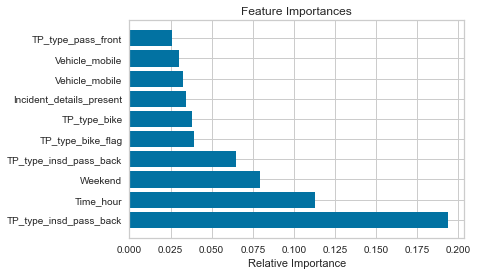

In [14]:
model = full_pipe.steps[2][1]
n_pcs= model.components_.shape[0]
initial_feature_names = features.columns
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
zipped_feats = zip(most_important_names, full_pipe.steps[3][1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features_col, importances = zip(*zipped_feats)
top_features = features_col[:10]
top_importances = importances[:10]
plt.title("Feature Importances")
plt.barh(range(len(top_importances)), top_importances, color="b", align="center")
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel("Relative Importance")
plt.show()

# Pickle Predictive and Target Pipeline

Both trained (__Regression__ and __Target__) pipelines are saved in pickle format for future use with new unseen data

In [15]:
# Pickle Predictive Pipeline
dump(full_pipe, open("model.pkl", "wb"))

# Pickle Target Pipeline
dump(target_pipeline, open("target.pkl", "wb"))

# Test Data Prepration

- Partition test data to seprate feature and target
- Seprate ID column for future use

In [16]:
features_testdata = strat_test_set.drop(['Incurred', 'Claim Number', 'Incurred_cat'], axis = 1)
target_testdata = strat_test_set['Incurred']

# Drop ID Column and save it for future use
id_col_testdata = strat_test_set['Claim Number']

# Use Trained Predictive Pipeline

In [17]:
predictions_test = full_pipe.predict(features_testdata)

In [18]:
y_pred = pd.DataFrame(target_pipeline.inverse_transform(predictions_test.reshape(-1,1)), columns = ["predictions"])
y_actuals = pd.DataFrame(target_testdata , columns = ["actuals"])

data_comb = [y_pred, y_actuals]

y_check = pd.concat([id_col_testdata, y_pred, target_testdata], axis = 1)

mae = mean_absolute_error(target_pipeline.inverse_transform(predictions_test.reshape(-1,1)), target_testdata)
print(f"Mean Absolute Error of Test Data: {round(mae, 2)}")

Mean Absolute Error of Test Data: 2699.52


In [19]:
y_check.head(50)

,Claim Number,predictions,Incurred
0,6689,22.611,0.000
1,2237,14798.183,9571.048
2,1349,3826.262,2890.385
3,1180,3086.135,3008.016
4,7513,10.602,0.000
5,5391,4.127,0.000
6,3335,14.669,0.000
7,3960,21001.740,65023.748
8,1306,2940.443,2235.702
9,6981,18.775,0.000


In [21]:
output_path = r"C:\Users\kumar\OneDrive\Desktop\Akshat\insurance\Output"
now = datetime.now()
y_check.to_excel(str(output_path) + r"/Incurance Ultimate Claim - Data Load " + now.strftime("%d%B%y") + ".xlsx", index = False, header = True)